# OTT & POT

The goal of this notebook is to compare {class}`OTT's <ott.solvers.linear.sinkhorn.Sinkhorn>` to 
the [Python Optimal Transport (POT)](https://pythonot.github.io/) implementation of {func}`Sinkhorn <ot.sinkhorn>`. `POT` can also use a `JAX` backbone, but unlike `OTT`, it cannot benefit from just-in-time compilation. We will see this can play a role for smaller scale problems. We also compare their APIs and highlight a few differences.

The comparisons carried out below have limitations: minor modifications in the setup (e.g., data distributions, tolerance thresholds, accelerator...) could have an impact on these results. Feel free to change these settings and experiment by yourself!

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install -q POT

In [ ]:
import timeit

import jax
import jax.numpy as jnp
import numpy as np
import ot

import matplotlib.pyplot as plt

plt.rc("font", size=20)
import mpl_toolkits.axes_grid1

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## Regularized OT in a nutshell

We consider two probability measures $\mu,\nu$ compared with the squared-Euclidean distance, $c(x,y)=\|x-y\|^2$. These measures are discrete and of the same size in this notebook:

$$\mu=\sum_{i=1}^n a_i\delta_{x_i},\quad \nu =\sum_{j=1}^n b_j\delta_{y_j},$$

to define the OT problem in its primal form,

$$\min_{P \in U(a,b)} \langle C, P \rangle - \varepsilon H(P).$$

where $U(a,b):=\{P \in \mathbf{R}_+^{n\times n}, P\mathbf{1}_{n}=b, P^T\mathbf{1}_n=b\}$, and $C = [ \|x_i - y_j \|^2 ]_{i,j}\in \mathbf{R}_+^{n\times n}$, and $H$ is the Shannon entropy of $P$, $H(P)=-\sum_{ij} P_{ij} \left(\log P_{ij}-1\right)$.

That problem is equivalent to the following dual form,

$$\max_{f, g} \langle a, f \rangle + \langle b, g \rangle - \varepsilon \langle e^{f/\varepsilon},Ke^{g/\varepsilon} \rangle +\varepsilon.$$

These two problems can be solved by `OTT` and `POT` using the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` iterations with a simple initialization for $u$, and subsequent updates $v \leftarrow a / K^Tu, u \leftarrow b / Kv$,  where $K:=e^{-C/\varepsilon}$.

Upon convergence to fixed points $u^*, v^*$, one has $P^*=D(u^*)KD(v^*)$ or, alternatively, 
$f^*, g^* = \varepsilon \log(u^*), \varepsilon\log(v^*)$.

## OTT and POT implementation

Both toolboxes can carry out the Sinkhorn updates as described in the formulas above (this corresponds to `lse_mode=False` in `OTT` and `method='sinkhorn'` in `POT`), but most practitioners will find that doing computations in log-space yields more robust computations, notably in low regularization regimes.

`OTT` relies on log-space iterations (`lse_mode=True`), whereas `POT`, uses a stabilization trick (`method='sinkhorn_stabilized'`) to avoid numerical overflows, by re-updating the kernel matrix regularly.

The default behavior of `OTT` is to carry out these updates until $\|u\circ Kv - a\|_1 + \|v\circ K^Tu - b\|_1$ is smaller than the user-defined `threshold`. `POT` uses instead the $\|\cdot\|_2$ norm of these terms. Thankfully, `OTT` can consider other norms by setting the `norm_error` parameter, in this case to `2` to facilitate comparisons.

## Common API for `OTT` and `POT`

We will compare in our experiments `OTT` vs. `POT` in their more stable setups (`lse_mode` and `log` respectively). We define a common API that takes as inputs the measures' information, the targeted $\varepsilon$ value and the `threshold` used to terminate the algorithm. We recover dual potential vectors $f$ and $g$, and the dual objective of these dual vectors (without the regularization, as done for `POT`). We set a maximum of $10,000$ iterations for both.

In [3]:
def solve_ot(a, b, x, y, 𝜀, threshold):
    # you can also try "sinkhorn_stabilized", this is a bit faster but less stable for small 𝜀
    method = "sinkhorn_log"
    _, log = ot.sinkhorn(
        a,
        b,
        ot.dist(x, y),
        𝜀,
        stopThr=threshold,
        method=method,
        log=True,
        numItermax=1000,
    )
    # dealing with POT quirks
    logu = "log_u" if method == "sinkhorn_log" else "logu"
    logv = "log_v" if method == "sinkhorn_log" else "logv"
    n_iter_key = "niter" if method == "sinkhorn_log" else "n_iter"
    # center dual variables
    f, g = 𝜀 * log[logu], 𝜀 * log[logv]
    f, g = f - np.mean(f), g + np.mean(f)
    converged = log["err"][-1] < threshold
    reg_ot = np.sum(f * a) + np.sum(g * b) if converged else jnp.nan
    return f, g, reg_ot, log[n_iter_key]


@jax.jit
def solve_ott(a, b, x, y, 𝜀, threshold):
    n = x.shape[0]
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=a, b=b)
    solver = sinkhorn.Sinkhorn(
        threshold=threshold,
        max_iterations=1000,
        norm_error=2,
        lse_mode=True,
    )
    out = solver(prob)
    # center dual variables to facilitate comparison
    f, g = out.f, out.g
    f, g = f - np.mean(f), g + np.mean(f)
    reg_ot = jnp.where(out.converged, jnp.sum(f * a) + jnp.sum(g * b), jnp.nan)
    return f, g, reg_ot, out.n_iters

To test both solvers, we run simulations using a random seed to generate random point clouds of size $n$. Random generation is carried out using {func}`~jax.random.PRNGKey`, to ensure reproducibility. A solver specification `solver_spec` provides three items: the function, using our common API, its numerical environment and its name. Next, provide information on GPU used.

In [4]:
!nvidia-smi --query-gpu=gpu_name --format=csv

name
NVIDIA GeForce RTX 2080 Ti
NVIDIA GeForce RTX 2080 Ti


In [5]:
def sample_points(rng, n, dim):
    rng, *rngs = jax.random.split(rng, 5)
    x = jax.random.uniform(rngs[0], (n, dim))
    y = (jax.random.normal(rngs[1], (n, dim)) + 0.5) / 5
    a = jax.random.uniform(rngs[2], (n,)) + 0.1
    b = jax.random.uniform(rngs[3], (n,)) + 0.1
    a, b = a / jnp.sum(a), b / jnp.sum(b)
    return a, b, x, y


def run_simulation(a, b, x, y, 𝜀, threshold, solver_spec):
    # extract specificities of solver.
    solver, env, name = solver_spec
    # run solver once
    out = solver(a, b, x, y, 𝜀, threshold)
    print(" n_iters:", out[-1], end=" |")
    # record timings
    timeit_res = %timeit -o solver(a, b, x, y, 𝜀, threshold)
    exec_time = np.nan if np.isnan(out[-1]) else timeit_res.average
    return exec_time, out

Defines the three solvers used in this experiment: ``POT``, ``POT`` with a ``JAX`` backend, and ``OTT``. 

In [6]:
POT = (solve_ot, "np", "POT")
POT_jax = (solve_ot, "jax", "POT-jax-backbone")
OTT = (solve_ott, "jax", "OTT")

## Run simulations with varying $n$ and $\varepsilon$

We run simulations by setting the regularization strength $\varepsilon$ to either $10^{-2}$ or $10^{-1}$.

We consider $n$ between sizes $2^{8}= 256$ and $2^{15}= 32768$.  We do not go higher, because `POT` runs into out-of-memory errors for $2^{13}=8192$. `OTT` can avoid these by setting the flag `batch_size` to, e.g., 1024, as also handled by the [GeomLoss](https://www.kernel-operations.io/geomloss/) toolbox. We leave the comparison with `GeomLoss` to a future notebook. 

When `%timeit` outputs execution time, **notice the warning message** highlighting the fact that, for `OTT`, at least one run took significantly longer. That run is that doing the **JIT pre-compilation** of the procedure, suitable for that particular problem size $n$. Once pre-compiled, subsequent runs are order of magnitudes faster, thanks to the {func}`~jax.jit` decorator added to `solve_ott`.

In [9]:
solvers = (POT, POT_jax, OTT)
n_range = 2 ** np.arange(9, 15)
# epsilon regularization is set using multiples of mean of cost matrix
# this can be seen as very-low, medium & high regularization regimes.
# Note that the default setting in OTT-JAX uses the last choice
# (1/20th of the mean cost).
𝜀_scales = [0.01, 0.025, 0.05]
dim = 6

exec_time = {}
reg_ot_costs = {}
n_iters = {}

#  setting global variables helps avoir a timeit bug.
global a, b, x, y, solver

for solver_spec in solvers:
    solver, env, name = solver_spec
    print("----- ", name)
    exec_time[name] = np.ones((len(n_range), len(𝜀_scales))) * np.nan
    reg_ot_costs[name] = np.ones((len(n_range), len(𝜀_scales))) * np.nan
    n_iters[name] = np.ones((len(n_range), len(𝜀_scales))) * np.nan
    for j, 𝜀_scale in enumerate(𝜀_scales):
        for i, n in enumerate(n_range):
            rng = jax.random.PRNGKey(i)
            # Compute a relevant scale for 𝜀
            a, b, x, y = sample_points(rng, n, dim)
            # this computes mean of cost matrix
            epsilon_base = pointcloud.PointCloud(x, y).mean_cost_matrix
            𝜀 = epsilon_base * 𝜀_scale
            # map to numpy if needed
            if env == "np":
                a, b, x, y = map(np.array, (a, b, x, y))
            # check dtype consistency across experiments
            assert x.dtype == "float32"

            # Set a threshold that scales with n
            threshold_n = 0.01 / (n**0.33)
            print(
                "n:",
                n,
                ", 𝜀_scale:",
                𝜀_scale,
                f", 𝜀: {𝜀:.5f}",
                f", thr.: {threshold_n:.5f}",
                end=" ",
            )
            t, out = run_simulation(a, b, x, y, 𝜀, threshold_n, solver_spec)
            _, _, reg_ot_cost, n_it = out
            exec_time[name][i, j] = t
            reg_ot_costs[name][i, j] = reg_ot_cost
            # Check convergence.
            assert not jnp.isnan(reg_ot_cost)
            n_iters[name][i, j] = n_it

-----  POT
n: 512 , 𝜀_scale: 0.01 , 𝜀: 0.01720 , thr.: 0.00128  n_iters: 40 |234 ms ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
n: 1024 , 𝜀_scale: 0.01 , 𝜀: 0.01741 , thr.: 0.00102  n_iters: 40 |555 ms ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
n: 2048 , 𝜀_scale: 0.01 , 𝜀: 0.01690 , thr.: 0.00081  n_iters: 40 |2.74 s ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
n: 4096 , 𝜀_scale: 0.01 , 𝜀: 0.01703 , thr.: 0.00064  n_iters: 40 |13.6 s ± 9.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
n: 8192 , 𝜀_scale: 0.01 , 𝜀: 0.01704 , thr.: 0.00051  n_iters: 40 |52.3 s ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
n: 16384 , 𝜀_scale: 0.01 , 𝜀: 0.01695 , thr.: 0.00041  n_iters: 30 |2min 42s ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
n: 512 , 𝜀_scale: 0.025 , 𝜀: 0.04299 , thr.: 0.00128  n_iters: 20 |128 ms ± 615 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
n: 1024 , 𝜀_scale: 0.025 , 𝜀: 0.04352 , thr

## Plot results: time and objective

We plot below all 3 runs for each of the 3 solvers. When using `POT` with a JAX backbone, the speed-up we get by using `JIT` in `OTT` is more apparent for smaller scale problems. Indeed, for larger scale problems, most of the compute effort is spent on kernel vector products, which, in this case, are comparably implemented across platforms.

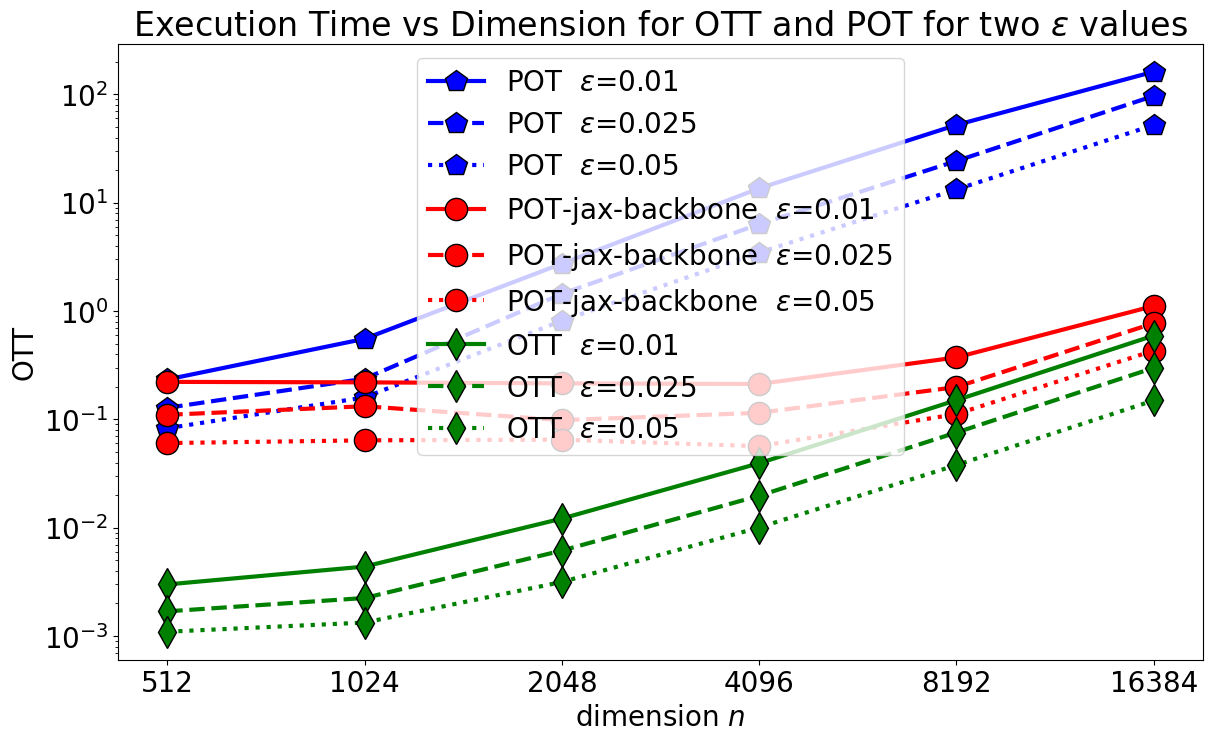

In [11]:
list_legend = []
fig = plt.figure(figsize=(14, 8))

metric = exec_time
name = "Execution time"
for solver_spec, marker, col in zip(
    solvers, ("p", "o", "d"), ("blue", "red", "green")
):
    solver, env, name = solver_spec
    p = plt.plot(
        metric[name],
        marker=marker,
        color=col,
        markersize=16,
        markeredgecolor="k",
        lw=3,
    )
    p[0].set_linestyle("-")
    p[1].set_linestyle("--")
    p[2].set_linestyle(":")
    list_legend += [name + r"  $\varepsilon $=" + f"{𝜀:.2g}" for 𝜀 in 𝜀_scales]
plt.xticks(ticks=np.arange(len(n_range)), labels=n_range)
plt.legend(list_legend)
plt.yscale("log")
plt.xlabel("dimension $n$")
plt.ylabel(name)
plt.title(
    r"Execution Time vs Dimension for OTT and POT for two $\varepsilon$ values"
)
plt.show()

In [31]:
meth = "OTT"


def plot_bsl(bsl):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    im = ax.imshow(reg_ot_costs[meth].T - reg_ot_costs[bsl].T)
    plt.xticks(ticks=np.arange(len(n_range)), labels=n_range)
    plt.yticks(ticks=np.arange(len(𝜀_scales)), labels=𝜀_scales)
    plt.xlabel("dimension $n$")
    plt.ylabel(r"regularization $\varepsilon$")
    title = (
        "Gap in objective "
        + bsl
        + " / "
        + meth
        + " , >0 when "
        + meth
        + " is better"
    )
    plt.title(title)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    plt.show()

For good measure, we also show the differences in *objectives* between the two solvers. We subtract the objective returned by `POT` and `POT-JAX` to that returned by `OTT`.

Since the problem is evaluated in its dual form, a **higher objective is better**, and therefore a positive difference denotes a better performance for `OTT`.

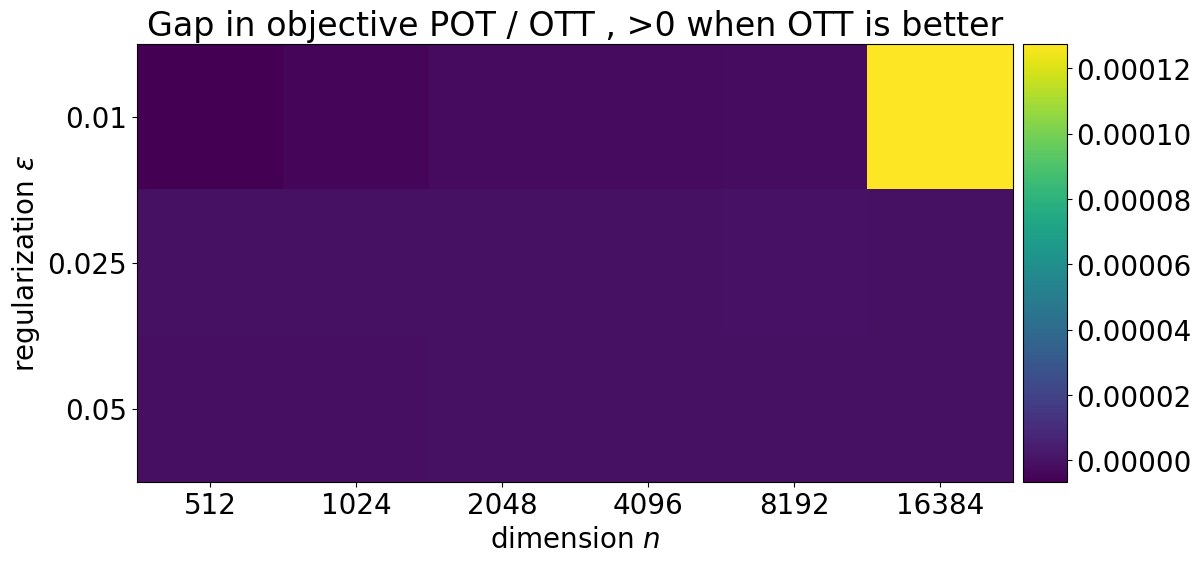

In [33]:
plot_bsl("POT")

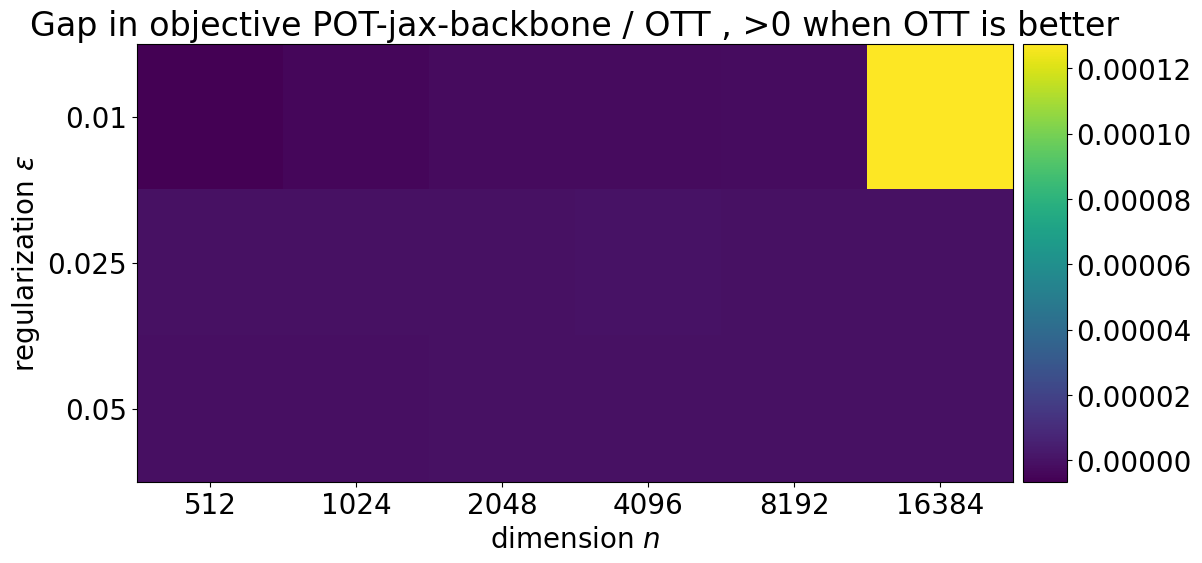

In [32]:
plot_bsl("POT-jax-backbone")